In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join('%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join('%s-images-idx3-ubyte.gz'% kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
# Read Fashion MNIST dataset

X_train, y_train =load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

# Pre-Processing

X_test, X_val = train_test_split(X_test, test_size=0.5, random_state = 2)
y_test,y_val = train_test_split(y_test, test_size=0.5, random_state = 2)

Y_train = y_val
Y_val = y_val
Y_test = y_test

X_test = X_test/255
X_train = X_train/255
X_val = X_val/255

print("train_images:", X_train.shape)
print("train_images:", y_train.shape)
print("test_images:", X_test.shape)
print("test_images:", y_test.shape)

# One hot encoding the labeled data

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
print(y_train)

train_images: (60000, 784)
train_images: (60000,)
test_images: (5000, 784)
test_images: (5000,)
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# One Hidden Layer Neural Network from Scratch

def sigmoid(s):
    return 1/(1 + np.exp(-s))

def sigmoid_derv(s):
    return s * (1 - s)

def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def derivate_cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples

def cross_entropy(pred, real):
    n = real.shape[0]
    logp = - np.log(pred[np.arange(n), real.argmax(axis=1)])
    loss = np.sum(logp)/n
    return loss

In [0]:
class MyNN:
    def __init__(self, x, y, lr):
        self.x = x
        neurons = 400
        self.lr = lr
        ip_dim = x.shape[1]
        op_dim = y.shape[1]

        self.w1 = np.random.randn(ip_dim, neurons)
        self.b1 = np.zeros((1, neurons))
        self.w2 = np.random.randn(neurons, op_dim)
        self.b2 = np.zeros((1, op_dim))
        
        self.y = y

    def feedforward(self):
        z1 = np.dot(self.x, self.w1) + self.b1
        self.a1 = sigmoid(z1)
        
        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = softmax(z2)
        
    def backprop(self):
        loss = cross_entropy(self.a2, self.y)
        #print('Error :', loss)
        


        w2_der = np.dot(self.a1.T, derivate_cross_entropy(self.a2, self.y))
        
        w1_der = np.dot(self.x.T, (np.dot(derivate_cross_entropy(self.a2, self.y), self.w2.T) * sigmoid_derv(self.a1)))

      

        self.w1 -= self.lr * w1_der
        self.b2 -= self.lr*np.sum(derivate_cross_entropy(self.a2, self.y), axis=0)
        self.w2 -= self.lr * w2_der
        self.b1 -= self.lr*np.sum((np.dot(derivate_cross_entropy(self.a2, self.y), self.w2.T) * sigmoid_derv(self.a1)), axis=0)
        return loss

    def predict(self, data):
        self.x = data
        #print(self.x)
        self.feedforward()
        return self.a2.argmax()

In [7]:
# Training the model 

model = MyNN(X_train, np.array(y_train), 1)
x = [1000]
losses=[]
acc=[]
for i in range(len(x)):
  for epoch in range(x[i]):
    model.feedforward()
    losses.append(model.backprop())
print(len(losses))

1000


Text(0, 0.5, 'Loss')

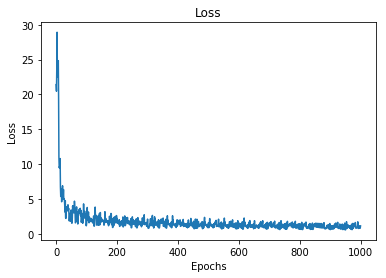

In [9]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [10]:
# Getting Accuracy
output =[]
def get_acc(x, y):
    
    acc = 0
    for xx,yy in zip(x, y):
        s = model.predict(xx)
        output.append(s)
        if s == np.argmax(yy):
            acc +=1
    return acc/len(x)*100

#print("Training accuracy : ", get_acc(X_train, np.array(y_train)))
#print("Validation accuracy : ", get_acc(X_val, np.array(y_val)))
print("Test accuracy : ", get_acc(X_test, np.array(y_test)))
print(len(output))

Test accuracy :  79.80000000000001
5000


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(Y_test, output))
print(classification_report(Y_test, output))

[[276   8   2  39   0   3 164   0   5   0]
 [  0 483   0  15   2   0   7   0   2   0]
 [  5   5 230  19  93   0 151   0   1   1]
 [  3   5   0 429  11   0  35   1   2   0]
 [  0   1  11  19 366   2  96   0   3   0]
 [  1   1   0   0   0 447   0  28   5   9]
 [ 24   1  22  28  43   0 385   0  14   0]
 [  0   0   0   0   0  17   0 447   2  26]
 [  0   1   0   7   6   4  18   2 458   0]
 [  0   0   0   1   0   8   0  31   0 469]]
              precision    recall  f1-score   support

           0       0.89      0.56      0.68       497
           1       0.96      0.95      0.95       509
           2       0.87      0.46      0.60       505
           3       0.77      0.88      0.82       486
           4       0.70      0.73      0.72       498
           5       0.93      0.91      0.92       491
           6       0.45      0.74      0.56       517
           7       0.88      0.91      0.89       492
           8       0.93      0.92      0.93       496
           9       0.93     

In [0]:
import matplotlib.pyplot as plt
from keras.callbacks import History

def plot_history(history):
  
  loss_values = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
  val_loss_values = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
  acc_values = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
  val_acc_values = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
  
  if len(loss_values) == 0:
    print("Incomplete Data")
    return
  
  no_epochs = range(1, len(history.history[loss_values[0]]) + 1)
  plt.figure(1)
  for l in loss_values:
    plt.plot(no_epochs, history.history[l], 'b', label = 'Training loss')
  for l in val_loss_values:
    plt.plot(no_epochs, history.history[l], 'g', label = 'Validation loss')
    
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  
  plt.figure(2)  
  for l in acc_values:
    plt.plot(no_epochs, history.history[l], 'b', label = 'Training accuracy')
  for l in val_acc_values:
    plt.plot(no_epochs, history.history[l], 'g', label = 'Validation Accuracy')
    
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout()
  plt.show()
 

In [23]:
# Multi Hidden Layer Neural Network using Keras

import keras, time
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(200, input_dim=784, activation='sigmoid'))
model.add(Dense(160, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.1),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=10, epochs=15, verbose=1, validation_data=(X_test, y_test))

_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))
print(model.summary())

Train on 60000 samples, validate on 5000 samples
Epoch 1/15
60000/60000 [==============================] - 23s 384us/step - loss: 1.4756 - acc: 0.3996 - val_loss: 0.8768 - val_acc: 0.6150
Epoch 2/15
60000/60000 [==============================] - 21s 351us/step - loss: 0.7748 - acc: 0.6991 - val_loss: 0.6835 - val_acc: 0.7422
Epoch 3/15
60000/60000 [==============================] - 21s 344us/step - loss: 0.6184 - acc: 0.7706 - val_loss: 0.6306 - val_acc: 0.7690
Epoch 4/15
60000/60000 [==============================] - 22s 362us/step - loss: 0.5383 - acc: 0.8056 - val_loss: 0.5275 - val_acc: 0.8102
Epoch 5/15
60000/60000 [==============================] - 22s 372us/step - loss: 0.4840 - acc: 0.8283 - val_loss: 0.5062 - val_acc: 0.8242
Epoch 6/15
60000/60000 [==============================] - 21s 356us/step - loss: 0.4514 - acc: 0.8402 - val_loss: 0.5754 - val_acc: 0.8086
Epoch 7/15
60000/60000 [==============================] - 21s 345us/step - loss: 0.4289 - acc: 0.8480 - val_loss: 0.4

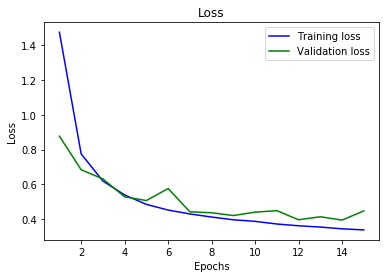

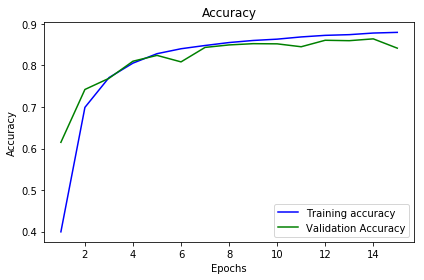

In [24]:
plot_history(history)

In [27]:
y_pred = model.predict(X_test, batch_size=10, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
y_pred = np.argmax(y_pred, axis=1)

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

[[260   0   6  14   1   0 212   0   4   0]
 [  1 488   0  12   3   0   5   0   0   0]
 [  3   0 424   6  17   0  53   0   2   0]
 [  2   2   1 436   8   1  32   0   4   0]
 [  0   0 102  21 303   0  70   0   2   0]
 [  0   0   0   1   0 469   0  14   3   4]
 [ 12   0  52  13  12   0 425   0   3   0]
 [  0   0   0   0   0  18   0 467   0   7]
 [  0   0   1   2   1   3  11   2 476   0]
 [  0   0   0   0   0  11   0  38   0 460]]
              precision    recall  f1-score   support

           0       0.94      0.52      0.67       497
           1       1.00      0.96      0.98       509
           2       0.72      0.84      0.78       505
           3       0.86      0.90      0.88       486
           4       0.88      0.61      0.72       498
           5       0.93      0.96      0.94       491
           6       0.53      0.82      0.64       517
           7       0.90      0.95      0.92       492
           8       0.96      0.96      0.96       496
           9       0.98     

In [0]:
# Pre Processing for CNN

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_val = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [30]:
# CNN using Keras

from keras.layers.convolutional import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
import tensorflow as tf

tf.model = Sequential()
tf.model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
tf.model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tf.model.add(Conv2D(64, (5, 5), activation='relu'))
tf.model.add(MaxPooling2D(pool_size=(2, 2)))
tf.model.add(Flatten())
tf.model.add(Dense(100, activation='relu'))
tf.model.add(Dense(10, activation='softmax'))

tf.model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.1), metrics=['accuracy'])

history = tf.model.fit(X_train, y_train, batch_size=10, epochs=15, verbose=1, validation_data=(X_test, y_test))

print(model.summary())

Train on 60000 samples, validate on 5000 samples
Epoch 1/15
60000/60000 [==============================] - 98s 2ms/step - loss: 0.5010 - acc: 0.8124 - val_loss: 0.3864 - val_acc: 0.8548
Epoch 2/15
60000/60000 [==============================] - 98s 2ms/step - loss: 0.3398 - acc: 0.8757 - val_loss: 0.3754 - val_acc: 0.8580
Epoch 3/15
60000/60000 [==============================] - 97s 2ms/step - loss: 0.3086 - acc: 0.8851 - val_loss: 0.3639 - val_acc: 0.8692
Epoch 4/15
60000/60000 [==============================] - 96s 2ms/step - loss: 0.2858 - acc: 0.8934 - val_loss: 0.3354 - val_acc: 0.8754
Epoch 5/15
60000/60000 [==============================] - 96s 2ms/step - loss: 0.2687 - acc: 0.8991 - val_loss: 0.3602 - val_acc: 0.8758
Epoch 6/15
60000/60000 [==============================] - 96s 2ms/step - loss: 0.2560 - acc: 0.9029 - val_loss: 0.3296 - val_acc: 0.8808
Epoch 7/15
60000/60000 [==============================] - 96s 2ms/step - loss: 0.2429 - acc: 0.9092 - val_loss: 0.3283 - val_acc:

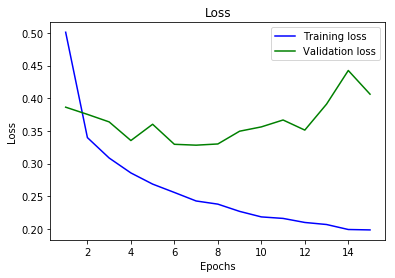

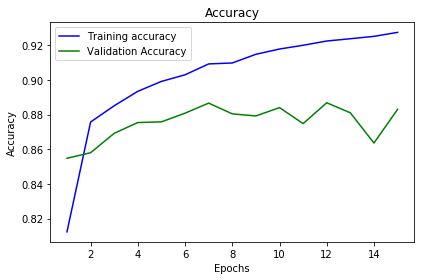

In [31]:
plot_history(history)

In [33]:
y_pred = tf.model.predict(X_test, batch_size=10, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
y_pred = np.argmax(y_pred, axis=1)

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

[[350   1  10  21   1   0 109   0   5   0]
 [  0 498   0   7   2   0   2   0   0   0]
 [  9   1 408   8  39   1  39   0   0   0]
 [  4   3   6 445  19   0   7   1   1   0]
 [  0   0  30  11 427   0  30   0   0   0]
 [  1   0   0   0   0 478   0  12   0   0]
 [ 29   3  33  20  58   1 367   0   6   0]
 [  0   0   0   0   0   6   0 472   0  14]
 [  2   1   2   1   2   0   5   3 480   0]
 [  0   0   0   0   0   1   0  17   1 490]]
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       497
           1       0.98      0.98      0.98       509
           2       0.83      0.81      0.82       505
           3       0.87      0.92      0.89       486
           4       0.78      0.86      0.82       498
           5       0.98      0.97      0.98       491
           6       0.66      0.71      0.68       517
           7       0.93      0.96      0.95       492
           8       0.97      0.97      0.97       496
           9       0.97     